In [82]:
import tensorflow_addons as tfa

In [83]:
import keras as K
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [84]:
import sys
sys.path.append('../segmentation_helper')

import data_loader as dl
import model_broker as mb

In [85]:
image_size = 128
channels = 3
loader = dl.DataLoader(IMAGE_SIZE=image_size)

In [86]:
train_img, test_img = loader.import_processed_img()

In [87]:
train_combine, test_combine = loader.import_raw_combined()
train_combine = train_combine.map(lambda x:[x["image"],x["segmentation_mask"]])
test_combine = test_combine.map(lambda x:[x["image"],x["segmentation_mask"]])

In [92]:
image = next(iter(train_img))[0]

In [93]:
img_inputs = K.Input(shape=image.shape)

In [94]:
def mlp(x, hidden_units, dropout):
    for units in hidden_units:
        x = K.layers.Dense(units, activation=tf.nn.gelu)(x)
        x = K.layers.Dropout(dropout)(x)
    return x

In [95]:
class Patches(K.layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

In [96]:
patch_size=10

Image size: 128 X 128
Patch size: 10 X 10
Patches per image: 144
Elements per patch: 300


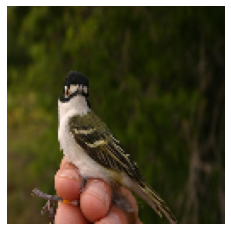

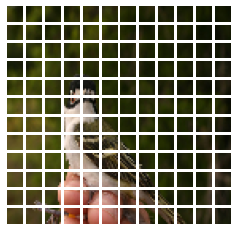

In [97]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = next(iter(train_img.take(8)))
plt.imshow(image[0])
plt.axis("off")

patches = Patches(patch_size)(image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img)
    plt.axis("off")

In [98]:
class PatchEncoder(K.layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = K.layers.Dense(units=projection_dim)
        self.position_embedding = K.layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [99]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 100

input_shape = next(iter(train_img))[0].shape
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]
num_heads = 4

In [100]:
input_shape

TensorShape([128, 128, 3])

In [101]:
segshape=[128,128,1]

In [102]:
def im2seg_transformer():
    inputs = K.layers.Input(shape=input_shape)
    patches = Patches(patch_size)(inputs)
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    for _ in range(transformer_layers):
        x1 = K.layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        attention_output = K.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        x2 = K.layers.Add()([attention_output, encoded_patches])
        x3 = K.layers.LayerNormalization(epsilon=1e-6)(x2)
        x3 = mlp(x3, hidden_units=transformer_units, dropout=0.1)
        encoded_patches = K.layers.Add()([x3, x2])

    representation = K.layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = K.layers.Flatten()(representation)
    representation = K.layers.Dropout(0.5)(representation)
    features = mlp(representation, hidden_units=mlp_head_units, dropout=0.5)
    output = K.layers.Dense(np.prod(segshape), activation="sigmoid")(features)
    output = tf.reshape(output,(-1,128,128,1))
    # Create the Keras model.
    model = K.Model(inputs=inputs, outputs=output,)
    return model

In [103]:
model = im2seg_transformer()

In [104]:
def dice_coef(y_true, y_pred):
    y_true_f = K.backend.flatten(y_true)
    y_pred_f = K.backend.flatten(y_pred)
    intersection = K.backend.sum(y_true_f * y_pred_f)

    return (2. * intersection) / (K.backend.sum(y_true_f) + K.backend.sum(y_pred_f))

def diceCoefLoss(y_true, y_pred):
    return (1-dice_coef(y_true, y_pred))

In [105]:
model.compile(
    optimizer=tfa.optimizers.AdamW(weight_decay=0.0001),
    loss=diceCoefLoss,
    metrics=[
        K.metrics.bce,
    ],
)

In [106]:
history = model.fit(train_combine.batch(64).prefetch(tf.data.AUTOTUNE),epochs=20)

Epoch 1/20
47/47 [==============================] - 636s 13s/step - loss: 0.4643 - binary_crossentropy: 2.9304
Epoch 2/20
47/47 [==============================] - 594s 13s/step - loss: 0.4489 - binary_crossentropy: 3.0328
Epoch 3/20
47/47 [==============================] - 591s 13s/step - loss: 0.4487 - binary_crossentropy: 3.0283
Epoch 4/20
 3/47 [>.............................] - ETA: 9:33 - loss: 0.4351 - binary_crossentropy: 2.9841


KeyboardInterrupt



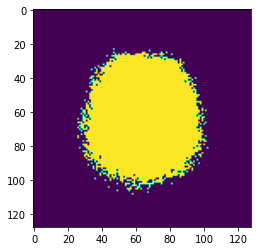

In [107]:
import matplotlib.pyplot as plt
plt.imshow(model(tf.reshape(next(iter(train_img)),(-1,128,128,3)))[0])